In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
df = pd.read_csv("/Users/kassraniroumand/code/aitrading/aitrading/data/eurousd_df_clean_2.csv")

In [1]:
# Convert 'timestamp' to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['datetime'])

# Sort the dataframe by timestamp to ensure correct operations
df = df.sort_values(by='timestamp')

# Calculate the target variable by comparing the current price to the next
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

# Time-based features (example: part of the day)
df['hour'] = df['timestamp'].dt.hour
df['part_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Convert day of week to cyclic features
df['sin_day'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

In [2]:
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [3]:
df['price_change_5_intervals'] = df['close'].diff(periods=5)

# Rolling window features (example: rolling average over the last 5 intervals)
df['rolling_avg_price_10_intervals'] = df['close'].rolling(window=5).mean()
df['rolling_avg_price_10_close_intervals'] = df['low'].rolling(window=5).mean()


# Drop any rows with NaN values created by shifts and rolling functions
df.dropna(inplace=True)

# Display the first few rows to inspect the new features
# df
df['ma_30m'] = df['close'].rolling(window=5).mean()  # 1-hour MA
df['ma_24h'] = df['close'].rolling(window=288).mean()  # 24-hour MA
df['ema_30min'] = df['close'].ewm(span=6, adjust=False).mean()  # 1-hour EMA
df['ema_24h'] = df['close'].ewm(span=288, adjust=False).mean()  # 24-hour EMA
df['rsi'] = calculate_rsi(df['close'], window=5)
df.dropna(inplace=True)

In [105]:
def enrich_dataframe(df, datetime_col='datetime'):
    """
    Enriches the input DataFrame with financial analytics features. Validates the presence of required columns
    including a dynamic datetime column, 'close', and 'low' before proceeding. Adds time-based features, moving
    averages, price change, RSI, and more.

    Parameters:
    - df: pandas DataFrame.
    - datetime_col: str, name of the column in df that contains datetime information.

    Returns:
    - DataFrame enriched with additional financial features if validation passes. Otherwise, raises ValueError.
    """
    # Validation: Check for necessary columns
    required_columns = [datetime_col, 'close', 'low']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {', '.join(missing_columns)}")

    # Convert datetime column to pandas Timestamp and sort the DataFrame
    df['timestamp'] = pd.to_datetime(df[datetime_col])
    df.sort_values(by='timestamp', inplace=True)

    # Calculate the target variable
    df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

    # Time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['part_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['sin_day'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Price change and rolling window features
    df['price_change_5_intervals'] = df['close'].diff(periods=5)
    df['rolling_avg_price_10_intervals'] = df['close'].rolling(window=5).mean()
    df['rolling_avg_price_10_close_intervals'] = df['low'].rolling(window=5).mean()

    # Moving averages
    df['ma_30m'] = df['close'].rolling(window=5).mean()
    df['ma_24h'] = df['close'].rolling(window=288).mean()

    # Exponential moving averages
    df['ema_30min'] = df['close'].ewm(span=6, adjust=False).mean()
    df['ema_24h'] = df['close'].ewm(span=288, adjust=False).mean()

    # Relative Strength Index (RSI)
    df['rsi'] = calculate_rsi(df['close'], window=14)

    # Drop rows with NaN values
    df.dropna(inplace=True)

    return df


In [106]:
enrich_dataframe(df)

,datetime,open,high,low,close,volume,timestamp,target,hour,part_of_day,...,sin_day,cos_day,price_change_5_intervals,rolling_avg_price_10_intervals,rolling_avg_price_10_close_intervals,ma_30m,ma_24h,ema_30min,ema_24h,rsi
7776,2021-02-12 00:10:00,1.13214,1.13232,1.13214,1.13227,315,2021-02-12 00:10:00,1,0,Night,...,-0.433884,-0.900969,-0.02590,1.142584,1.142436,1.142584,1.158544,1.141666,1.158149,2.631579
7777,2021-02-12 00:15:00,1.13226,1.13237,1.13209,1.13232,324,2021-02-12 00:15:00,1,0,Night,...,-0.433884,-0.900969,-0.02578,1.137428,1.137238,1.137428,1.158446,1.138996,1.157971,2.818448
7778,2021-02-12 00:20:00,1.13232,1.13240,1.13230,1.13239,250,2021-02-12 00:20:00,1,0,Night,...,-0.433884,-0.900969,-0.02596,1.132236,1.132080,1.132236,1.158349,1.137109,1.157794,3.078051
7779,2021-02-12 00:25:00,1.13238,1.13244,1.13230,1.13241,306,2021-02-12 00:25:00,1,0,Night,...,-0.433884,-0.900969,0.00035,1.132306,1.132176,1.132306,1.158252,1.135766,1.157618,3.149030
7780,2021-02-12 00:30:00,1.13242,1.13251,1.13237,1.13248,410,2021-02-12 00:30:00,1,0,Night,...,-0.433884,-0.900969,0.00034,1.132374,1.132240,1.132374,1.158154,1.134827,1.157444,2.828802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179147,2024-12-03 23:35:00,1.09255,1.09257,1.09245,1.09251,364,2024-12-03 23:35:00,1,23,Evening,...,0.781831,0.623490,-0.00025,1.092650,1.092602,1.092650,1.092373,1.092634,1.090725,28.813559
179148,2024-12-03 23:40:00,1.09251,1.09257,1.09247,1.09252,343,2024-12-03 23:40:00,0,23,Evening,...,0.781831,0.623490,-0.00017,1.092616,1.092560,1.092616,1.092428,1.092601,1.090737,29.411765
179149,2024-12-03 23:45:00,1.09252,1.09256,1.09249,1.09252,435,2024-12-03 23:45:00,0,23,Evening,...,0.781831,0.623490,-0.00029,1.092558,1.092520,1.092558,1.092483,1.092578,1.090750,30.973451
179150,2024-12-03 23:50:00,1.09252,1.09254,1.09235,1.09241,404,2024-12-03 23:50:00,0,23,Evening,...,0.781831,0.623490,-0.00028,1.092502,1.092452,1.092502,1.092537,1.092530,1.090761,33.333333


In [10]:
# Define split ratios
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Calculate indices for splits
total_samples = len(df)
train_end = int(total_samples * train_ratio)
validation_end = int(train_end + total_samples * validation_ratio)

# Split the dataset
train_data = df.iloc[:train_end]
validation_data = df.iloc[train_end:validation_end]
test_data = df.iloc[validation_end:]


X_train, y_train = train_data.drop(['target', 'timestamp', 'hour'], axis=1), train_data['target']
X_val, y_val = validation_data.drop(['target', 'timestamp', 'hour'], axis=1), validation_data['target']
X_test, y_test = test_data.drop(['target', 'timestamp', 'hour'], axis=1), test_data['target']


print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 125578
Validation set size: 26909
Test set size: 26911


In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Normalize numerical features, replacing 'price' with 'close'
scaler = StandardScaler()
# numeric_features = ['close', 'price_change_5_intervals', 'rolling_avg_price_5_intervals']  # Adjust feature names as needed
numeric_features = [
    'close',
                    'price_change_5_intervals',
                    'rolling_avg_price_10_close_intervals',
                    'rolling_avg_price_10_intervals',
                    'sin_day',
                    'cos_day',
                    # 'ma_30min',
                      'ma_24h',
                  'ema_30min',
                  'ema_24h',
                    'rsi'
                    ]  # Adjust feature names as needed
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
categorical_features = ['part_of_day']  # Ensure this is present or adjust accordingly
# categorical_features = ['part_of_day']  # Ensure this is present or adjust accordingly
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])
X_val_encoded = encoder.transform(X_val[categorical_features])

# Concatenate encoded categorical features back with numerical features
X_train_preprocessed = np.concatenate((X_train[numeric_features].values, X_train_encoded), axis=1)
X_val_preprocessed = np.concatenate((X_val[numeric_features].values, X_val_encoded), axis=1)
X_test_preprocessed = np.concatenate((X_test[numeric_features].values, X_test_encoded), axis=1)

/Users/kassraniroumand/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
from keras.src.layers import Bidirectional
from keras.src.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [13]:
X_train_reshaped = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1]))
X_test_reshaped = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1]))
X_val_reshaped = X_val_preprocessed.reshape((X_val_preprocessed.shape[0], 1, X_val_preprocessed.shape[1]))
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_val_categorical = to_categorical(y_val)

In [14]:
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh'), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
# model.add(Dropout(0.2))
model.add(LSTM(100, activation='tanh'))
# model.add(Dropout(0.2))
# model.add(LSTM(100, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))  # Assuming binary classification

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Compile the model

# Train the model
# history = model.fit(X_train_reshaped, y_train_categorical, epochs=100, batch_size=32, validation_ratio=0.2, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.001)

history = model.fit(
    X_train_reshaped,
    y_train_categorical, 
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped,y_val_categorical),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


/Users/kassraniroumand/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3925/3925 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5118 - loss: 0.6928 - val_accuracy: 0.5082 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 2/100
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5167 - loss: 0.6926 - val_accuracy: 0.5092 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 3/100
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.5163 - loss: 0.6925 - val_accuracy: 0.5080 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 4/100
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.5189 - loss: 0.6924 - val_accuracy: 0.5083 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 5/100
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5186 - loss: 0.6924 - val_accuracy: 0.5081 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 6/100
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5178 - loss: 0.6924 - val_accuracy: 0.5073 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 7/100
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5159 - loss:

In [15]:
# Evaluate the model
_, accuracy = model.evaluate(X_test_reshaped, y_test_categorical, verbose=0)
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.51


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 200)         │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,408 (2.42 MB)

 Trainable params: 211,802 (827.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 423,606 (1.62 MB)

In [17]:
from matplotlib import pyplot as plt

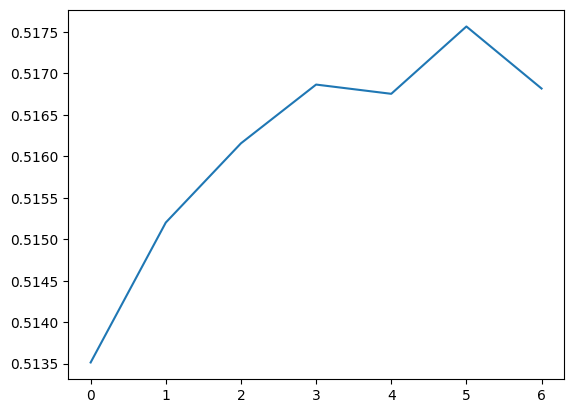

In [18]:
plt.plot(history.history['accuracy'], label='train')

841/841 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step


(array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 5.000e+00, 6.000e+00, 1.100e+01, 1.200e+01,
         1.900e+01, 3.800e+01, 5.800e+01, 6.300e+01, 7.200e+01, 1.260e+02,
         1.290e+02, 1.780e+02, 1.360e+02, 1.640e+02, 2.230e+02, 2.920e+02,
         3.260e+02, 4.260e+02, 4.440e+02, 6.000e+02, 5.320e+02, 5.150e+02,
         4.630e+02, 4.760e+02, 4.850e+02, 4.360e+02, 4.280e+02, 4.170e+02,
         3.890e+02, 3.650e+02, 3.870e+02, 3.560e+02, 3.900e+02, 3.060e+02,
         3.560e+02, 3.710e+02, 3.650e+02, 3.910e+02, 4.090e+02, 4.350e+02,
         4.440e+02, 5.120e+02, 6.360e+02, 7.400e+02, 1.143e+03, 1.037e+03,
         9.370e+02, 1.051e+03, 1.292e+03, 1.047e+03, 1.336e+03, 1.359e+03,
         5.450e+02, 4.020e+02, 5.750e+02, 6.140e+02, 4.570e+02, 1.630e+02,
         1.070e+02, 1.150

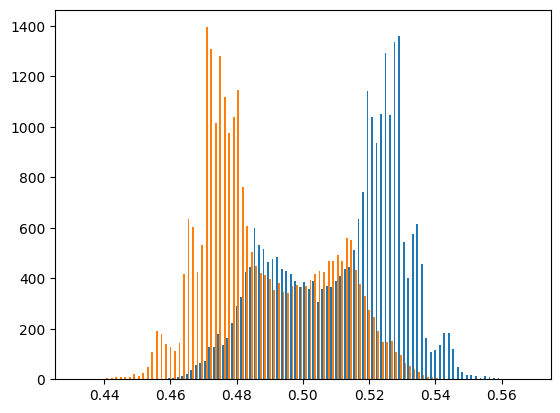

In [19]:
plt.hist(model.predict(X_test_reshaped),bins=100)

In [36]:
X_test_reshaped.shape

In [35]:
print()
x = X_test_reshaped.loc[0,:,:]
x

(26911, 1, 13)


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [32]:
model.predict(x)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [31]:
plt.hist(model.predict(x) > 0.52,bins=100)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


(array([[22232.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,  4679.],
        [10449.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         

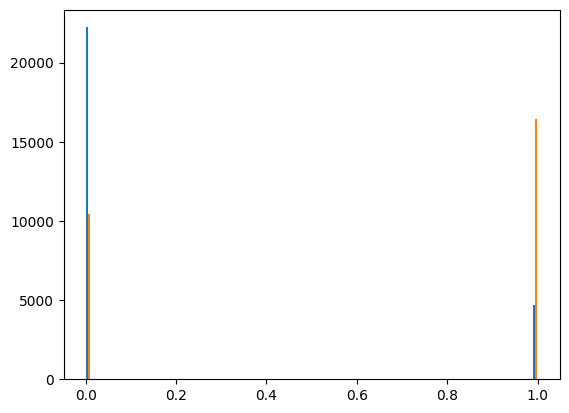

In [21]:
plt.hist(model.predict(X_test_reshaped) <  0.49,bins=100)

In [22]:
len(pd.DataFrame(model.predict(X_test_reshaped)))

841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


26911

In [23]:
len(X_test_reshaped)

26911

In [24]:
pred = pd.DataFrame(model.predict(X_test_reshaped))

841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


In [25]:
pred[pred[0] > 0.52]

,0,1
0,0.527999,0.471898
1,0.529030,0.470897
2,0.529515,0.470425
3,0.527414,0.472474
4,0.530669,0.469372
...,...,...
26900,0.525252,0.474640
26901,0.528594,0.471333
26902,0.524000,0.475896
26903,0.526191,0.473702


In [26]:
pred[pred[1] > 0.52]

,0,1
181,0.474330,0.526508
182,0.474099,0.526756
183,0.474461,0.526339
184,0.474659,0.526116
185,0.474348,0.526451
...,...,...
26820,0.467396,0.532580
26821,0.474382,0.525115
26908,0.479115,0.521233
26909,0.479207,0.521136


In [39]:
import requests

In [93]:
# get current timestamp in the format required by the API 2024-04-02-11:44
import datetime
now = datetime.datetime.now() - datetime.timedelta(hours=1)
now = now.strftime("%Y-%m-%d-%H:%M")
# compute for last 50 minutes
start = datetime.datetime.now() - datetime.timedelta(hours=2)
start = start.strftime("%Y-%m-%d-%H:%M")
print(f"start {start}, now {now}")

start 2024-04-02-12:24, now 2024-04-02-13:24


In [95]:
url = f"https://marketdata.tradermade.com/api/v1/timeseries?currency=EURUSD&api_key=zNv02V5PnDlZwEQypn1j&start_date={start}&end_date={now}&format=records&interval=minute&period=1"
res = requests.get(url).json()

In [99]:
quote = pd.DataFrame(res['quotes'])

In [100]:
quote

,close,date,high,low,open
0,1.07476,2024-04-02 12:24:00,1.07476,1.07463,1.07468
1,1.07479,2024-04-02 12:25:00,1.07482,1.07471,1.07475
2,1.07472,2024-04-02 12:26:00,1.07480,1.07471,1.07478
3,1.07478,2024-04-02 12:27:00,1.07478,1.07468,1.07472
4,1.07472,2024-04-02 12:28:00,1.07480,1.07469,1.07478
...,...,...,...,...,...
56,1.07590,2024-04-02 13:20:00,1.07592,1.07560,1.07564
57,1.07585,2024-04-02 13:21:00,1.07590,1.07585,1.07590
58,1.07580,2024-04-02 13:22:00,1.07593,1.07578,1.07585
59,1.07580,2024-04-02 13:23:00,1.07586,1.07580,1.07580


In [107]:
enrich_dataframe(quote, "date")

,close,date,high,low,open,timestamp,target,hour,part_of_day,day_of_week,sin_day,cos_day,price_change_5_intervals,rolling_avg_price_10_intervals,rolling_avg_price_10_close_intervals,ma_30m,ma_24h,ema_30min,ema_24h,rsi
